In [1]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yfinance as yf
import nsepython as nse
import datetime 
import time
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error



In [2]:
# Inputs
# Date input
from_date = datetime.date(year=2014,month=1,day=1).strftime("%Y-%m-%d")
to_date = (datetime.date(year=2025,month=8,day=7)).strftime("%Y-%m-%d")
print(datetime.datetime.now(),' : Date inputs taken!')



2025-08-07 09:29:52.727234  : Date inputs taken!


In [3]:
df = yf.download('^NSEI',start=from_date,end=to_date)
df.columns = ['CLOSE','HIGH','LOW','OPEN','VOLUME']
df.drop('VOLUME',axis=1,inplace=True)
df['Date'] = df.index

act_price = float(df.iloc[-1,0])

for i in ['CLOSE','HIGH','LOW','OPEN']:
    df[i] = df[i].pct_change()*100

df.dropna(inplace=True)


print(datetime.datetime.now(),' : Data loaded and featured configured!')
act_price

/tmp/ipykernel_6087/3988808552.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('^NSEI',start=from_date,end=to_date)
[*********************100%***********************]  1 of 1 completed

2025-08-07 09:29:53.496669  : Data loaded and featured configured!


24574.19921875

In [4]:
# Additional feature generation 
for k in [3,5,9,13,20,50,100,200]:
    for j in ['OPEN','HIGH','LOW','CLOSE']:
        df[f'{j}_MA_{k}'] = df[j].rolling(window=k).mean()
        df[f'{j}_STD_{k}'] = df[j].rolling(window=k).std()
       
df.dropna(inplace=True)
df
# df['NXT_OPEN'] = df['OPEN'].shift(-1)
# print(datetime.datetime.now(),' : Additional features generated!')

,CLOSE,HIGH,LOW,OPEN,Date,OPEN_MA_3,OPEN_STD_3,HIGH_MA_3,HIGH_STD_3,LOW_MA_3,...,CLOSE_MA_100,CLOSE_STD_100,OPEN_MA_200,OPEN_STD_200,HIGH_MA_200,HIGH_STD_200,LOW_MA_200,LOW_STD_200,CLOSE_MA_200,CLOSE_STD_200
Date,,,,,,,,,,,,,,,,,,,,,
2014-11-03,0.023434,0.238269,1.214930,1.796783,2014-11-03,1.109153,0.892241,1.031414,0.792675,1.006630,...,0.118956,0.822129,0.144482,0.868021,0.140488,0.911239,0.148022,0.792542,0.149042,0.819183
2014-11-05,0.169980,0.179031,0.311529,0.037129,2014-11-05,1.087893,0.928307,0.746973,0.932872,0.974072,...,0.122489,0.821575,0.153135,0.858178,0.152125,0.896606,0.152804,0.790618,0.150696,0.818888
2014-11-07,-0.015588,-0.062162,-0.399471,-0.232305,2014-11-07,0.533869,1.101981,0.118380,0.159134,0.375663,...,0.112627,0.817199,0.149850,0.858391,0.151573,0.896704,0.150888,0.791493,0.152203,0.818300
2014-11-10,0.086962,0.271522,0.171288,0.071415,2014-11-10,-0.041254,0.166341,0.129464,0.172276,0.027782,...,0.098873,0.805746,0.151570,0.857885,0.153188,0.896628,0.153810,0.790478,0.154996,0.817113
2014-11-11,0.220516,-0.051886,0.209519,0.195493,2014-11-11,0.011534,0.220096,0.052491,0.189756,-0.006221,...,0.091689,0.801372,0.154630,0.856939,0.155291,0.895645,0.153589,0.790456,0.155097,0.817119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-31,-0.348827,0.217647,-0.552840,-0.996972,2025-07-31,-0.184474,1.157474,0.090221,0.224454,-0.014293,...,0.107399,0.904610,-0.001818,1.009336,0.001704,0.795236,-0.001877,0.881529,-0.000303,0.855784
2025-08-01,-0.819594,-0.690600,-0.405720,0.375982,2025-08-01,0.173274,1.083212,-0.083665,0.525626,-0.084616,...,0.089919,0.905473,-0.000701,1.009631,-0.004368,0.795865,-0.005861,0.881545,-0.007680,0.856459
2025-08-04,0.640742,-0.193270,0.077233,-0.561351,2025-08-04,-0.394114,0.701589,-0.222074,0.454808,-0.293776,...,0.095980,0.907126,-0.006762,1.009339,-0.006374,0.795833,-0.005288,0.881561,-0.003071,0.857460


In [5]:
# 2500 datapoints collected
df = df[-2501:]  # Keep only the last 2500 rows
print(datetime.datetime.now(),' : Dataframe trimmed to last 2500 rows!')

2025-08-07 09:29:53.544962  : Dataframe trimmed to last 2500 rows!


In [6]:
df

,CLOSE,HIGH,LOW,OPEN,Date,OPEN_MA_3,OPEN_STD_3,HIGH_MA_3,HIGH_STD_3,LOW_MA_3,...,CLOSE_MA_100,CLOSE_STD_100,OPEN_MA_200,OPEN_STD_200,HIGH_MA_200,HIGH_STD_200,LOW_MA_200,LOW_STD_200,CLOSE_MA_200,CLOSE_STD_200
Date,,,,,,,,,,,,,,,,,,,,,
2015-06-15,0.388330,0.776678,0.057306,0.336062,2015-06-15,-0.141701,2.081483,-0.380719,1.482198,-0.328397,...,-0.027081,1.032115,0.028059,0.955491,0.030403,0.837041,0.025838,0.844606,0.029129,0.930332
2015-06-16,0.416775,0.051502,0.094401,0.220370,2015-06-16,-0.621365,1.559194,-0.407711,1.468857,-0.024616,...,-0.049080,0.998078,0.024637,0.953559,0.024099,0.832071,0.022612,0.843097,0.024584,0.926177
2015-06-17,0.549874,0.930308,1.214736,0.999475,2015-06-17,0.518636,0.420418,0.586163,0.469358,0.455481,...,-0.045895,0.999490,0.027781,0.955740,0.027371,0.834349,0.026014,0.846538,0.026525,0.926872
2015-06-18,1.026383,0.615100,0.656603,0.364909,2015-06-18,0.528252,0.414441,0.532303,0.445215,0.655247,...,-0.039965,1.004110,0.027088,0.955443,0.027894,0.834686,0.026477,0.846859,0.028287,0.928443
2015-06-19,0.615933,0.780514,1.158392,1.077809,2015-06-19,0.814065,0.390947,0.775307,0.157668,1.009910,...,-0.050752,0.990997,0.030601,0.958018,0.026423,0.833089,0.029678,0.849931,0.026070,0.926496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-31,-0.348827,0.217647,-0.552840,-0.996972,2025-07-31,-0.184474,1.157474,0.090221,0.224454,-0.014293,...,0.107399,0.904610,-0.001818,1.009336,0.001704,0.795236,-0.001877,0.881529,-0.000303,0.855784
2025-08-01,-0.819594,-0.690600,-0.405720,0.375982,2025-08-01,0.173274,1.083212,-0.083665,0.525626,-0.084616,...,0.089919,0.905473,-0.000701,1.009631,-0.004368,0.795865,-0.005861,0.881545,-0.007680,0.856459
2025-08-04,0.640742,-0.193270,0.077233,-0.561351,2025-08-04,-0.394114,0.701589,-0.222074,0.454808,-0.293776,...,0.095980,0.907126,-0.006762,1.009339,-0.006374,0.795833,-0.005288,0.881561,-0.003071,0.857460


In [7]:
# Date feature dropped
df = df.drop('Date',axis=1)
print(datetime.datetime.now(),' : date feature dropped!')  
df


2025-08-07 09:29:53.570390  : date feature dropped!


,CLOSE,HIGH,LOW,OPEN,OPEN_MA_3,OPEN_STD_3,HIGH_MA_3,HIGH_STD_3,LOW_MA_3,LOW_STD_3,...,CLOSE_MA_100,CLOSE_STD_100,OPEN_MA_200,OPEN_STD_200,HIGH_MA_200,HIGH_STD_200,LOW_MA_200,LOW_STD_200,CLOSE_MA_200,CLOSE_STD_200
Date,,,,,,,,,,,,,,,,,,,,,
2015-06-15,0.388330,0.776678,0.057306,0.336062,-0.141701,2.081483,-0.380719,1.482198,-0.328397,0.446105,...,-0.027081,1.032115,0.028059,0.955491,0.030403,0.837041,0.025838,0.844606,0.029129,0.930332
2015-06-16,0.416775,0.051502,0.094401,0.220370,-0.621365,1.559194,-0.407711,1.468857,-0.024616,0.175004,...,-0.049080,0.998078,0.024637,0.953559,0.024099,0.832071,0.022612,0.843097,0.024584,0.926177
2015-06-17,0.549874,0.930308,1.214736,0.999475,0.518636,0.420418,0.586163,0.469358,0.455481,0.657796,...,-0.045895,0.999490,0.027781,0.955740,0.027371,0.834349,0.026014,0.846538,0.026525,0.926872
2015-06-18,1.026383,0.615100,0.656603,0.364909,0.528252,0.414441,0.532303,0.445215,0.655247,0.560169,...,-0.039965,1.004110,0.027088,0.955443,0.027894,0.834686,0.026477,0.846859,0.028287,0.928443
2015-06-19,0.615933,0.780514,1.158392,1.077809,0.814065,0.390947,0.775307,0.157668,1.009910,0.307268,...,-0.050752,0.990997,0.030601,0.958018,0.026423,0.833089,0.029678,0.849931,0.026070,0.926496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-31,-0.348827,0.217647,-0.552840,-0.996972,-0.184474,1.157474,0.090221,0.224454,-0.014293,0.647908,...,0.107399,0.904610,-0.001818,1.009336,0.001704,0.795236,-0.001877,0.881529,-0.000303,0.855784
2025-08-01,-0.819594,-0.690600,-0.405720,0.375982,0.173274,1.083212,-0.083665,0.525626,-0.084616,0.687525,...,0.089919,0.905473,-0.000701,1.009631,-0.004368,0.795865,-0.005861,0.881545,-0.007680,0.856459
2025-08-04,0.640742,-0.193270,0.077233,-0.561351,-0.394114,0.701589,-0.222074,0.454808,-0.293776,0.329616,...,0.095980,0.907126,-0.006762,1.009339,-0.006374,0.795833,-0.005288,0.881561,-0.003071,0.857460


In [8]:
# Generate X_sample for prediction
X_sample = df.iloc[-1:,1:]
Today_open = input(f"Input opening price on {to_date} : ")
X_sample.iloc[:,-1] = Today_open

df.dropna(inplace=True)

print(datetime.datetime.now(),' : X_s# df = df[-2501:]ample generated!')  


2025-08-07 09:29:58.003405  : X_s# df = df[-2501:]ample generated!


/tmp/ipykernel_6087/4289583763.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.72' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  X_sample.iloc[:,-1] = Today_open


In [9]:
# train test data generation
X_train,X_test,y_train,y_test = train_test_split(df.drop('CLOSE',axis=1),df['CLOSE'],
                                                 test_size=0.2,random_state=11,
                                                 shuffle=False)
X_test = X_test[:500]
y_test = y_test[:500]  # Keep only the first 500 rows for testing
print(datetime.datetime.now(),' : Train/test data generated!')  




2025-08-07 09:29:58.011550  : Train/test data generated!


In [10]:
# Modeling
model = XGBRegressor()
print(datetime.datetime.now(),' : XGBoost model intialised!')  


2025-08-07 09:29:58.016566  : XGBoost model intialised!


In [11]:
# Model fitting
model.fit(X_train,y_train)
print(datetime.datetime.now(),' : Model fitted on train data!')  


2025-08-07 09:29:58.440226  : Model fitted on train data!


In [12]:
# Prediction
y_pred = model.predict(X_test)
print(datetime.datetime.now(),' : Predictions done for test data!') 


2025-08-07 09:29:58.453181  : Predictions done for test data!


In [13]:
# RMSE calculation
rmse = root_mean_squared_error(y_test,y_pred)
print(datetime.datetime.now(),' : RMSE performance metric calculated!') 


2025-08-07 09:29:58.460732  : RMSE performance metric calculated!


In [14]:
# Prediction table for test data
pred_table = pd.DataFrame()
pred_table['Actual'] = y_test
pred_table['Predicted'] = y_pred
pred_table['ABSError'] = abs(pred_table['Actual']-pred_table['Predicted'])
print(datetime.datetime.now(),' : Prediction table generated!') 



print(pred_table)

2025-08-07 09:29:58.468091  : Prediction table generated!
              Actual  Predicted  ABSError
Date                                     
2023-07-27 -0.598638  -0.879349  0.280711
2023-07-28 -0.070446  -0.037828  0.032618
2023-07-31  0.548456   0.504275  0.044181
2023-08-01 -0.102512   0.120463  0.222975
2023-08-02 -1.048975  -1.002033  0.046941
...              ...        ...       ...
2025-07-30  0.136784   0.054398  0.082386
2025-07-31 -0.348827   0.210290  0.559117
2025-08-01 -0.819594  -0.743117  0.076478
2025-08-04  0.640742   0.758596  0.117855
2025-08-05 -0.296080  -0.347348  0.051268

[500 rows x 3 columns]


In [15]:
avg_error = pred_table['ABSError'].mean()
print(f'On an average predictions are off by +/- {int(avg_error)} %')


On an average predictions are off by +/- 0 %


In [16]:
sample_pred = model.predict(np.array(X_sample))[0]

print(f"Close % change on {to_date} : {sample_pred}%")

Close % change on 2025-08-07 : -0.20503810048103333%


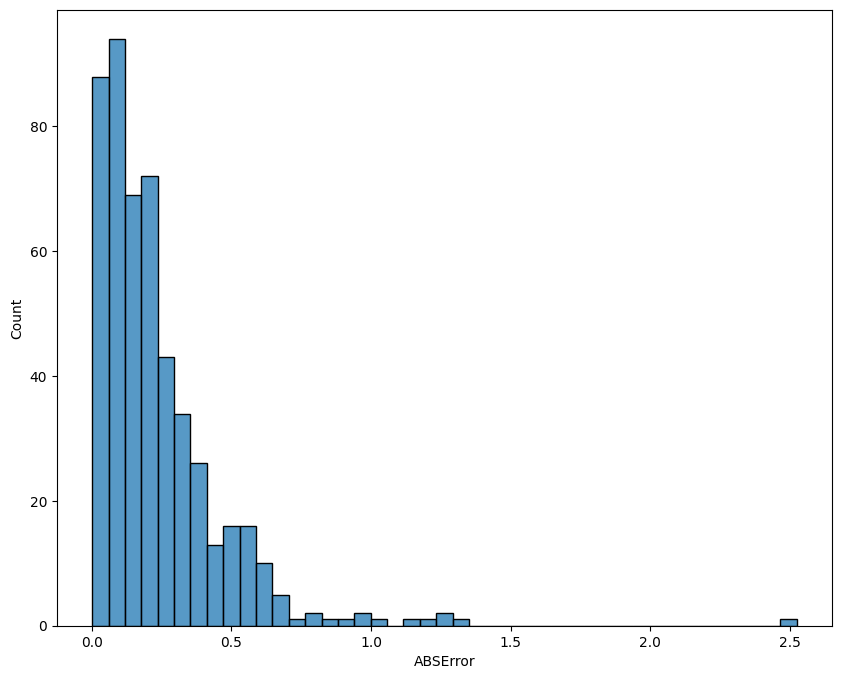

In [17]:
data = pred_table.reset_index()

plt.figure(figsize=(10,8))
sns.histplot(pred_table['ABSError'])
plt.show()

In [18]:
percentile = 85
val1 = np.percentile(a=pred_table['ABSError'],q=percentile)
predicted_range = (act_price*(100-val1)/100,act_price*(100+val1)/100)
print("For given test data")
print(f"Predicted values fall within  {predicted_range[0]} and {predicted_range[1]} of actual price with probability of 85%")


For given test data
Predicted values fall within  24474.000782036972 and 24674.397655463028 of actual price with probability of 85%


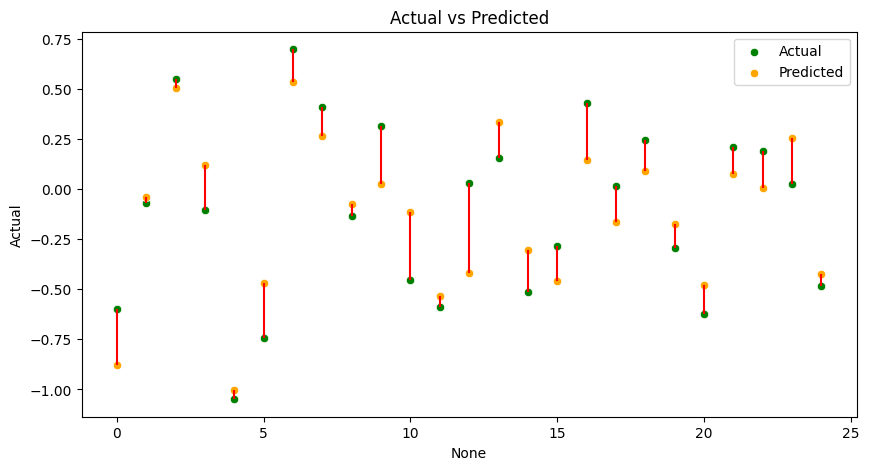

In [35]:
data = pred_table.reset_index()[:25]
plt.figure(figsize=(10,5))
sns.scatterplot(x=data.index,y=data['Actual'],color='green',label='Actual')
sns.scatterplot(x=data.index,y=data['Predicted'],color='orange',label='Predicted')
y_min = []
y_max = []
c = []
for y1,y2 in zip(data['Actual'],data['Predicted']):
    if y1>y2:
        y_min.append(y2)
        y_max.append(y1)

    else:
        y_min.append(y1)
        y_max.append(y2)


plt.vlines(x=data.index,ymin=y_min,ymax=y_max,color='red')

plt.title('Actual vs Predicted')
plt.legend()
plt.show()

In [ ]:
plt.vlines